In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import sklearn
from tqdm import tqdm
import skimage
from skimage import transform
from numpy import load
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, Concatenate, Input
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.makedirs("/content/Data", exist_ok=True)
!unzip "/content/drive/MyDrive/SysPracApp/DatasetRealSpoofedMerged.zip" -d "/content/Data"

In [ ]:
def get_data(folder,countMax):
    x = []
    y = []
    for folderName in os.listdir(folder):
        label = folderName
        print(label)
        for image_filename in tqdm(os.listdir(folder + "/" + folderName)[0:countMax]):
            img = cv2.imread(folder +'/' + folderName + '/' + image_filename)
            img = img[80:310,30:550]
            hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            hue_channel, _, _ = cv2.split(hsv_img)
            hue_channel_normalized = cv2.normalize(hue_channel, None, 0, 255, cv2.NORM_MINMAX)
            if img is not None:
                x.append(hue_channel_normalized)
                y.append(label)
    x = np.array(x)
    y = np.array(y)
    return x, y

def resizeData(data,imageSize):
  tmp = []
  for img in tqdm(data):
    tmp.append(skimage.transform.resize(img, (imageSize, imageSize)))
  return np.array(tmp)

def getClassMap(data):
  uniqueElements = list(set(data))
  classNo = 0
  classMap = {}
  for i in uniqueElements:
    classMap[i] = classNo
    classNo += 1
  return classMap

def replaceWithClass(data,classMap):
  tmp = []
  for i in range(0,len(data)):
    tmp.append(classMap[data[i]])
  return np.array(tmp)

def oneHotEncoding(a,size):
  return tf.one_hot(a.reshape(-1), size)

def getCorrectClass(tmpClass,classMap):
  for key, value in classMap.items():
         if value == tmpClass:
             return key

def getIndex(data):
  for i in range(0,len(data)):
    if(data[i]!=0):
      return i

def createFrames(file, output_folder):
  cap = cv2.VideoCapture(file)
  os.makedirs(output_folder, exist_ok=True)
  frame_count = 0
  while True:
      ret, frame = cap.read()
      if not ret:
          break
      frame_count += 1
      frame_path = os.path.join(output_folder, f'frame_{frame_count}.jpg')
      cv2.imwrite(frame_path, frame)

In [ ]:
x, y = get_data("/content/Data/",3000)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 2)
del x
del y

Real


100%|██████████| 3000/3000 [00:20<00:00, 148.94it/s]


Spoofed


100%|██████████| 3000/3000 [00:20<00:00, 146.88it/s]


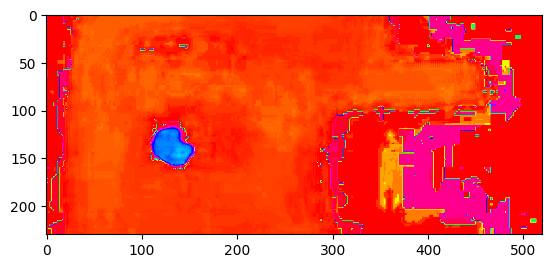

Spoofed


In [ ]:
rnd_idx = random.randint(0,len(x_train)-1)
img = x_train[rnd_idx][80:310,30:550]
plt.imshow(img, cmap='hsv')
plt.show()
print(y_train[rnd_idx])

In [ ]:
x_train = resizeData(x_train,300)
x_test = resizeData(x_test,300)

100%|██████████| 600/600 [00:04<00:00, 124.80it/s]


In [ ]:
classMap = getClassMap(y_train)
print(classMap)

y_train = replaceWithClass(y_train,classMap)
y_test = replaceWithClass(y_test,classMap)

y_train = oneHotEncoding(y_train,2)
y_test = oneHotEncoding(y_test,2)

{'Spoofed': 0, 'Real': 1}


Spoofed


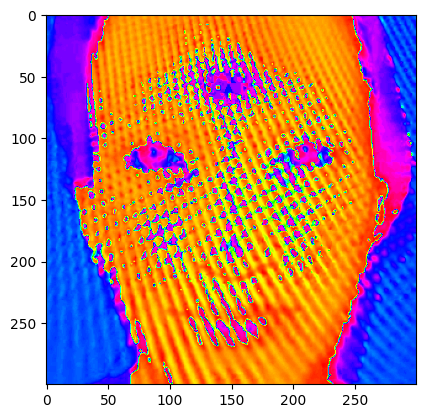

In [ ]:
rnd_idx = random.randint(0,len(x_train)-1)
img = x_train[rnd_idx]
label = y_train[rnd_idx]
label = getCorrectClass(getIndex(label),classMap)

print(label)
plt.imshow(img, cmap='hsv')
plt.show()

In [ ]:
input_shape = (300, 300)

(300, 300)
(5400, 300, 300)
(5400, 300, 300)


In [ ]:
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
BATCH_SIZE = 16

m = tf.keras.models.Sequential([
    tf.keras.layers.Input(input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="sigmoid"),
    tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(256, activation="sigmoid"),
#     tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation="sigmoid"),
    tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(1024, activation="sigmoid"),
#     tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2048, activation="sigmoid"),
    tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(4096, activation="sigmoid"),
#     tf.keras.layers.Dropout(0.5),chat
    tf.keras.layers.Dense(2, activation="softmax")
])

m.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = [ TruePositives(name='tp'), 
                         FalsePositives(name='fp'), 
                         TrueNegatives(name='tn'), 
                         FalseNegatives(name='fn'), 
                         "accuracy", 
                         Precision(name='precision'), 
                         Recall(name='recall'), 
                         AUC(name='auc')]
)
    
    
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(monitor = 'loss', patience = 8, mode = 'min', restore_best_weights = True)
history = m.fit(x_train, y_train, epochs=200, batch_size= BATCH_SIZE, callbacks=[earlyStopping])
m.evaluate(x=x_test, y=y_test)

Epoch 1/200
338/338 [==============================] - 11s 11ms/step - loss: 0.3865 - tp: 4434.0000 - fp: 966.0000 - tn: 4434.0000 - fn: 966.0000 - accuracy: 0.8211 - precision: 0.8211 - recall: 0.8211 - auc: 0.9060
Epoch 2/200
338/338 [==============================] - 3s 10ms/step - loss: 0.1281 - tp: 5163.0000 - fp: 237.0000 - tn: 5163.0000 - fn: 237.0000 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - auc: 0.9889
Epoch 3/200
338/338 [==============================] - 4s 13ms/step - loss: 0.1049 - tp: 5209.0000 - fp: 191.0000 - tn: 5209.0000 - fn: 191.0000 - accuracy: 0.9646 - precision: 0.9646 - recall: 0.9646 - auc: 0.9925
Epoch 4/200
338/338 [==============================] - 4s 12ms/step - loss: 0.0824 - tp: 5234.0000 - fp: 166.0000 - tn: 5234.0000 - fn: 166.0000 - accuracy: 0.9693 - precision: 0.9693 - recall: 0.9693 - auc: 0.9953
Epoch 5/200
338/338 [==============================] - 3s 10ms/step - loss: 0.0711 - tp: 5258.0000 - fp: 142.0000 - tn: 5258.0000 - fn: 142

[0.01313353143632412,
 598.0,
 2.0,
 598.0,
 2.0,
 0.996666669845581,
 0.996666669845581,
 0.996666669845581,
 0.998302698135376]

In [ ]:
m.save("/content/drive/MyDrive/SysPracApp/spoofingdetectormodel_hsv1.h5")

In [ ]:
classMap={'Spoofed': 0, 'Real': 1}

1/1 [==============================] - 0s 73ms/step
[[5.5059995e-06 9.9999452e-01]]
Real


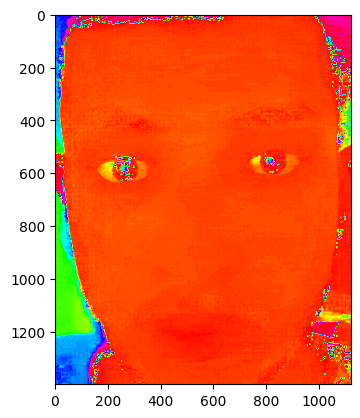

In [ ]:
import keras
m = keras.models.load_model('/content/drive/MyDrive/SysPracApp/spoofingdetectormodel_hsv1.h5')
img = cv2.imread("/content/drive/MyDrive/SysPracApp/val_spoofed2.jpg")
img = img[400:1800,630:1750]
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hue_channel, _, _ = cv2.split(hsv_img)
img = cv2.normalize(hue_channel, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(img, cmap = 'hsv')

img = skimage.transform.resize(img, (300,300))
pred = m.predict(img.reshape(1, img.shape[0], img.shape[1]))
pred_cls = np.argmax(pred)
print(pred)
print(getCorrectClass(pred_cls,classMap))

In [ ]:
# pred = m.predict(x_test)
# for i in range(len(x_test)):
#     prediction = class_map[np.argmax(pred[i])]
#     original = class_map[np.argmax(y_test[i])]
#     if  prediction != original:
# #         print(pred[i])
# #         print(y_test[i])
#         print(prediction, original)

19/19 [==============================] - 0s 2ms/step
Real Spoofed
Real Spoofed
